### Node2Vec Implementation Using networkx

In [1]:
import networkx as nx
from collections import defaultdict
import numpy as np
from gensim.models import Word2Vec
import matplotlib as plt

In [2]:
class MyNode2Vec:
    
    PROBABILITY_NAME = 'probabilities'
    
    def __init__(self,
                 graph: nx.Graph, 
                 embedding_dimension: int = 128, 
                 walk_length: int = 80, 
                 num_walks: int = 10,
                 p: float = 1, 
                 q: float = 1, 
                 weight_key: str = 'weight'):
        self.graph = graph
        self.embedding_dimension = embedding_dimension
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.walks = list()
        
        # Init dictionary. This dictionary will contain the new probabilities 
        # for each walk from every node in the graph
        self.probabilities = defaultdict(dict)
        for node in graph.nodes():
            self.probabilities[node][self.PROBABILITY_NAME] = dict()

    
    def compute_probabilities(self):
        
        G = self.graph    
            
        #Compute new probabilities using p, q 
        for source_node in G.nodes():
            # source_node = previous node (from current_node point of view)
            for current_node in G.neighbors(source_node):
                probs_current = list()
                for next_node in G.neighbors(current_node):
                    # next_node from current_node point of view
                    if next_node == source_node:
                        # inmediately revisit a node -> w' = w/p
                        prob = G[current_node][next_node].get('weight', 1)*(1/self.p)
                    elif next_node in G.neighbors(source_node):
                        # visit a node that is source_node's neighbor -> w' = w
                        prob = G[current_node][next_node].get('weight', 1)
                    else:
                        # visit a new node -> w' = w/q
                        prob = G[current_node][next_node].get('weight', 1)*(1/self.q)
                    probs_current.append(prob)
                self.probabilities[source_node][self.PROBABILITY_NAME][current_node] = probs_current/np.sum(probs_current)
                
    def node2vec_walk(self, start_node):
        G = self.graph
        walk = [start_node]
        
        next_nodes = list(G[start_node])
        # If start_node does not have any neighbor
        if len(next_nodes) == 0:
            return walk
        
        # First step must be random
        next_node = np.random.choice(next_nodes)
        walk.append(next_node)
        
        previous_node = start_node
        current_node = next_node
        
        # Next steps are obtained using the probabilities already computed
        for i in range(self.walk_length - 2):
            next_next_nodes = list(G[current_node])
            if (len(next_next_nodes) == 0):
                break
            #print(list(map(str, list(walk))))
            next_next_node = np.random.choice(next_next_nodes, 
                                              p=self.probabilities[previous_node][self.PROBABILITY_NAME][current_node])
            walk.append(next_next_node)
            previous_node = current_node
            current_node = next_next_node
        return walk
    
    def random_walks(self):
        G = self.graph
        walks = list()
        
        for start_node in G.nodes():
            for i in range(self.num_walks):
                walk = self.node2vec_walk(start_node)
                walks.append(walk)
        return walks
    
    def embed(self, walks):
        walks2 = [list(map(str, walk)) for walk in walks]
        model = Word2Vec(walks2,size=self.embedding_dimension)
        return model

    def learn_embeddings(self):
        self.compute_probabilities()
        random_walks = self.random_walks()
        model = self.embed(random_walks)
        return model

In [3]:
# Simple Graph (Testing Purposes)
G = nx.DiGraph()
G.add_edge('a', 'b', weight=0.6)
G.add_edge('a', 'c', weight=0.2)
G.add_edge('c', 'd', weight=0.1)
G.add_edge('c', 'e', weight=0.7)
G.add_edge('c', 'f', weight=0.9)
G.add_edge('a', 'd', weight=0.3)

{('a', 'b'): Text(0.7499999888241293, 0.433012741974907, '0.6'),
 ('a', 'c'): Text(0.24999998137354879, 0.4330127121725851, '0.2'),
 ('a', 'd'): Text(1.4901160971803051e-08, -1.9206817775722963e-08, '0.3'),
 ('c', 'd'): Text(-0.7500000037252903, 0.43301266846119746, '0.1'),
 ('c', 'e'): Text(-0.49999996274709757, -5.297752070365647e-09, '0.7'),
 ('c', 'f'): Text(-5.9604643887212205e-08, -5.297752070365647e-09, '0.9')}

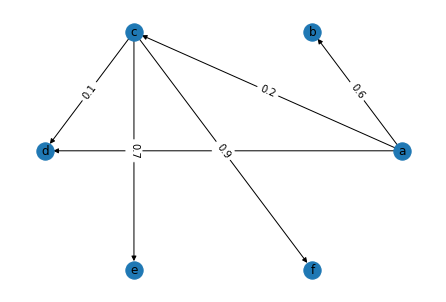

In [4]:
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)

In [5]:
g_n2v = MyNode2Vec(graph=G, 
               embedding_dimension=2, 
               walk_length=4, 
               num_walks=20, 
               p=2, 
               q=3)
g_model = g_n2v.learn_embeddings()

In [6]:
g_embeddings = g_model.wv[G.nodes()]
g_embeddings

array([[-0.21590066, -0.1599344 ],
       [ 0.22079204,  0.01173733],
       [ 0.09338623,  0.02455421],
       [ 0.05867868, -0.03996373],
       [ 0.01933734, -0.04123103],
       [ 0.19983579,  0.01150286]], dtype=float32)

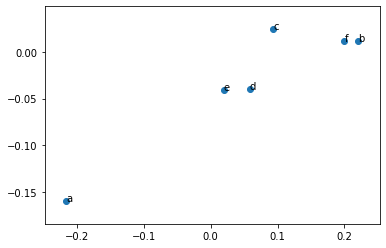

In [7]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = g_embeddings[:,0]
y = g_embeddings[:,1]
ax.scatter(x, y)

for i, node in enumerate(G.nodes()):
    ax.annotate(node, (x[i], y[i]))

In [8]:
# Let's add two very similar nodes to (b) and test if they appear close to (b)

{('a', 'b'): Text(0.8830222197173554, 0.3213938056005782, '0.6'),
 ('a', 'b1'): Text(0.5868241143768091, 0.4924038814676875, '0.6'),
 ('a', 'c'): Text(0.030153698191684564, -0.17101005599889452, '0.2'),
 ('a', 'd'): Text(0.250000049670537, -0.43301270118678475, '0.3'),
 ('b', 'b1'): Text(0.46984633409416454, 0.8137976672000509, '0.5'),
 ('b1', 'b2'): Text(-0.16317591045845936, 0.9254165727203649, '0.2'),
 ('b3', 'b2'): Text(-0.719846326643584, 0.6040228167903237, '0.2'),
 ('c', 'd'): Text(-0.7198462521377784, -0.6040227770538941, '0.1'),
 ('c', 'e'): Text(-0.38302221723382857, -0.6634139175983672, '0.7'),
 ('c', 'f'): Text(-0.08682414169560437, -0.49240393113822445, '0.9')}

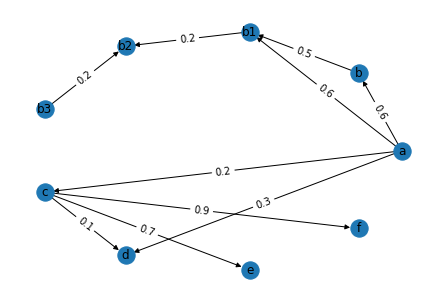

In [9]:
G1 = nx.DiGraph()
G1.add_edge('a', 'b', weight=0.6)
G1.add_edge('b', 'b1', weight=0.5)
G1.add_edge('a', 'b1', weight=0.6)
G1.add_edge('b1', 'b2', weight=0.2)
G1.add_edge('b3', 'b2', weight=0.2)
G1.add_edge('a', 'c', weight=0.2)
G1.add_edge('c', 'd', weight=0.1)
G1.add_edge('c', 'e', weight=0.7)
G1.add_edge('c', 'f', weight=0.9)
G1.add_edge('a', 'd', weight=0.3)
pos = nx.circular_layout(G1)
nx.draw(G1, pos, with_labels=True)
labels = nx.get_edge_attributes(G1,'weight')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=labels)

In [10]:
g1_n2v = MyNode2Vec(graph=G1, 
               embedding_dimension=2, 
               walk_length=4, 
               num_walks=20, 
               p=2, 
               q=3)
g1_model = g1_n2v.learn_embeddings()
g1_embeddings = g1_model.wv[list(map(str, G1.nodes()))]
g1_embeddings

array([[-0.21584848, -0.1599235 ],
       [ 0.22089475,  0.01186008],
       [-0.11816003, -0.15163808],
       [-0.15118192, -0.03261844],
       [ 0.19871448, -0.10809122],
       [ 0.09358127,  0.02444219],
       [ 0.05867868, -0.03996373],
       [ 0.01961225, -0.04121365],
       [ 0.20029144,  0.0114568 ]], dtype=float32)

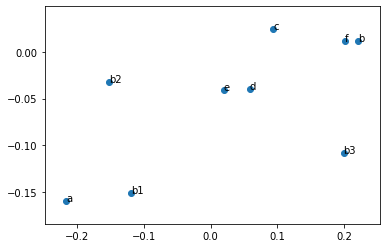

In [11]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = g1_embeddings[:,0]
y = g1_embeddings[:,1]
ax.scatter(x, y)

for i, node in enumerate(G1.nodes()):
    ax.annotate(node, (x[i], y[i]))

### Karate Club Graph

In [12]:
karate = nx.karate_club_graph()

In [61]:
karate_n2v = MyNode2Vec(graph=karate,
                       embedding_dimension=128,
                       walk_length=40,
                       num_walks=80,
                       p=1,
                       q=1)

In [62]:
karate_model = karate_n2v.learn_embeddings()

In [63]:
karate_embeddings = karate_model.wv[list(map(str,karate.nodes()))]

In [65]:
karate_model.most_similar('26')

/home/irene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('29', 0.9816133975982666),
 ('20', 0.9644716382026672),
 ('18', 0.9623520374298096),
 ('22', 0.9617142081260681),
 ('15', 0.941774308681488),
 ('14', 0.9309743642807007),
 ('32', 0.9123843908309937),
 ('33', 0.8953686356544495),
 ('23', 0.7876417636871338),
 ('8', 0.7118430137634277)]

#### Visualize embeddings using T-SNE

In [66]:
from sklearn.manifold import TSNE

In [67]:
karate_tsne_2 = TSNE(n_components=2, perplexity=5).fit_transform(karate_embeddings)

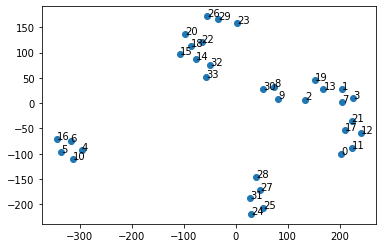

In [68]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = karate_tsne_2[:,0]
y = karate_tsne_2[:,1]
ax.scatter(x, y)

for i, node in enumerate(karate.nodes()):
    ax.annotate(node, (x[i], y[i]))

In [20]:
from node2vec import Node2Vec

In [56]:
karate_n2v_original = Node2Vec(graph=karate,
                       dimensions=128,
                       walk_length=40,
                       num_walks=80,
                       p=1,
                       q=1)

Generating walks (CPU: 1): 100%|██████████| 80/80 [00:05<00:00, 13.79it/s]


In [57]:
karate_model_original = karate_n2v_original.fit()

In [58]:
karate_embeddings_original = karate_model_original.wv[list(map(str,karate.nodes()))]

In [59]:
karate_tsne_original = TSNE(n_components=2, perplexity=5).fit_transform(karate_embeddings_original)

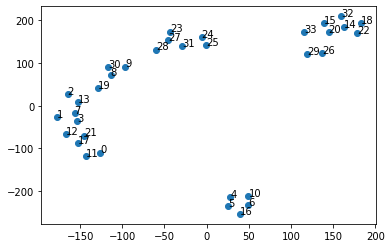

In [60]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots()
x = karate_tsne_original[:,0]
y = karate_tsne_original[:,1]
ax.scatter(x, y)

for i, node in enumerate(karate.nodes()):
    ax.annotate(node, (x[i], y[i]))

In [69]:
karate_model_original.most_similar('26')

/home/irene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('29', 0.9737737774848938),
 ('15', 0.9521702527999878),
 ('20', 0.9475634098052979),
 ('14', 0.9369577169418335),
 ('33', 0.9346071481704712),
 ('32', 0.9294766187667847),
 ('18', 0.9285781383514404),
 ('22', 0.9228181838989258),
 ('23', 0.785780668258667),
 ('9', 0.6451990604400635)]

Not very interesting, let's try with another graph

In [27]:
import pandas as pd

In [28]:
got_book1 = pd.read_csv("/home/irene/dev/notebooks-jupyter/got_dataset/book1.csv")
got_book1

,Source,Target,Type,weight,book
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1
...,...,...,...,...,...
679,Tyrion-Lannister,Willis-Wode,Undirected,4,1
680,Tyrion-Lannister,Yoren,Undirected,10,1
681,Tywin-Lannister,Varys,Undirected,4,1
682,Tywin-Lannister,Walder-Frey,Undirected,8,1


In [29]:
got_book1['weight'].mean()

10.769005847953217

In [30]:
# build graph from interactions (csv)
G_got = nx.Graph()
less_important_characters = list()
for _, edge in got_book1.iterrows():
        G_got.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])

In [31]:
G_got.nodes()

NodeView(('Addam-Marbrand', 'Jaime-Lannister', 'Tywin-Lannister', 'Aegon-I-Targaryen', 'Daenerys-Targaryen', 'Eddard-Stark', 'Aemon-Targaryen-(Maester-Aemon)', 'Alliser-Thorne', 'Bowen-Marsh', 'Chett', 'Clydas', 'Jeor-Mormont', 'Jon-Snow', 'Samwell-Tarly', 'Aerys-II-Targaryen', 'Brandon-Stark', 'Gerold-Hightower', 'Jon-Arryn', 'Robert-Baratheon', 'Aggo', 'Drogo', 'Jhogo', 'Jorah-Mormont', 'Quaro', 'Rakharo', 'Albett', 'Halder', 'Rast', 'Grenn', 'Pypar', 'Tyrion-Lannister', 'Alyn', 'Harwin', 'Jory-Cassel', 'Tomard', 'Arthur-Dayne', 'Arya-Stark', 'Benjen-Stark', 'Bran-Stark', 'Catelyn-Stark', 'Cersei-Lannister', 'Desmond', 'Ilyn-Payne', 'Jeyne-Poole', 'Joffrey-Baratheon', 'Meryn-Trant', 'Mordane', 'Mycah', 'Myrcella-Baratheon', 'Petyr-Baelish', 'Rickon-Stark', 'Robb-Stark', 'Rodrik-Cassel', 'Sandor-Clegane', 'Sansa-Stark', 'Syrio-Forel', 'Tommen-Baratheon', 'Vayon-Poole', 'Yoren', 'Arys-Oakheart', 'Balon-Greyjoy', 'Balon-Swann', 'Renly-Baratheon', 'Barristan-Selmy', 'Boros-Blount', 'Pyce

In [32]:
got_n2v = MyNode2Vec(graph=G_got,
          embedding_dimension=64,
          walk_length=20,
          num_walks=20,
          p=2,
          q=2)

In [33]:
got_model = got_n2v.learn_embeddings()

In [34]:
got_embeddings = got_model.wv[G_got.nodes()]

In [35]:
got_embeddings

array([[ 0.18219179,  0.08718643,  0.21959803, ...,  0.0471516 ,
        -0.06274003, -0.38983086],
       [ 0.30084872,  0.16867432,  0.18567559, ...,  0.29058403,
         0.02433695, -0.50652915],
       [ 0.36628056,  0.09505869,  0.1685249 , ...,  0.14077577,
         0.06313883, -0.45987725],
       ...,
       [ 0.3952166 ,  0.02838591,  0.3717015 , ..., -0.53216845,
        -0.07846662, -0.1915133 ],
       [ 0.3367614 ,  0.08827643,  0.22799525, ..., -0.20165755,
        -0.00903857, -0.3888541 ],
       [ 0.40215904,  0.13747369,  0.3641155 , ..., -0.25413287,
        -0.09152818, -0.5423874 ]], dtype=float32)

In [36]:
got_model.most_similar('Arya-Stark')

/home/irene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Sansa-Stark', 0.980262815952301),
 ('Mordane', 0.9641468524932861),
 ('Joffrey-Baratheon', 0.9485489130020142),
 ('Mycah', 0.9480590224266052),
 ('Tommen-Baratheon', 0.9460160732269287),
 ('Myrcella-Baratheon', 0.9458266496658325),
 ('Syrio-Forel', 0.9182742834091187),
 ('Jory-Cassel', 0.90451979637146),
 ('Jeyne-Poole', 0.8854192495346069),
 ('Meryn-Trant', 0.8565464615821838)]

In [70]:
from sklearn.decomposition import PCA

In [71]:
got_tsne = PCA(n_components=2).fit_transform(got_embeddings)

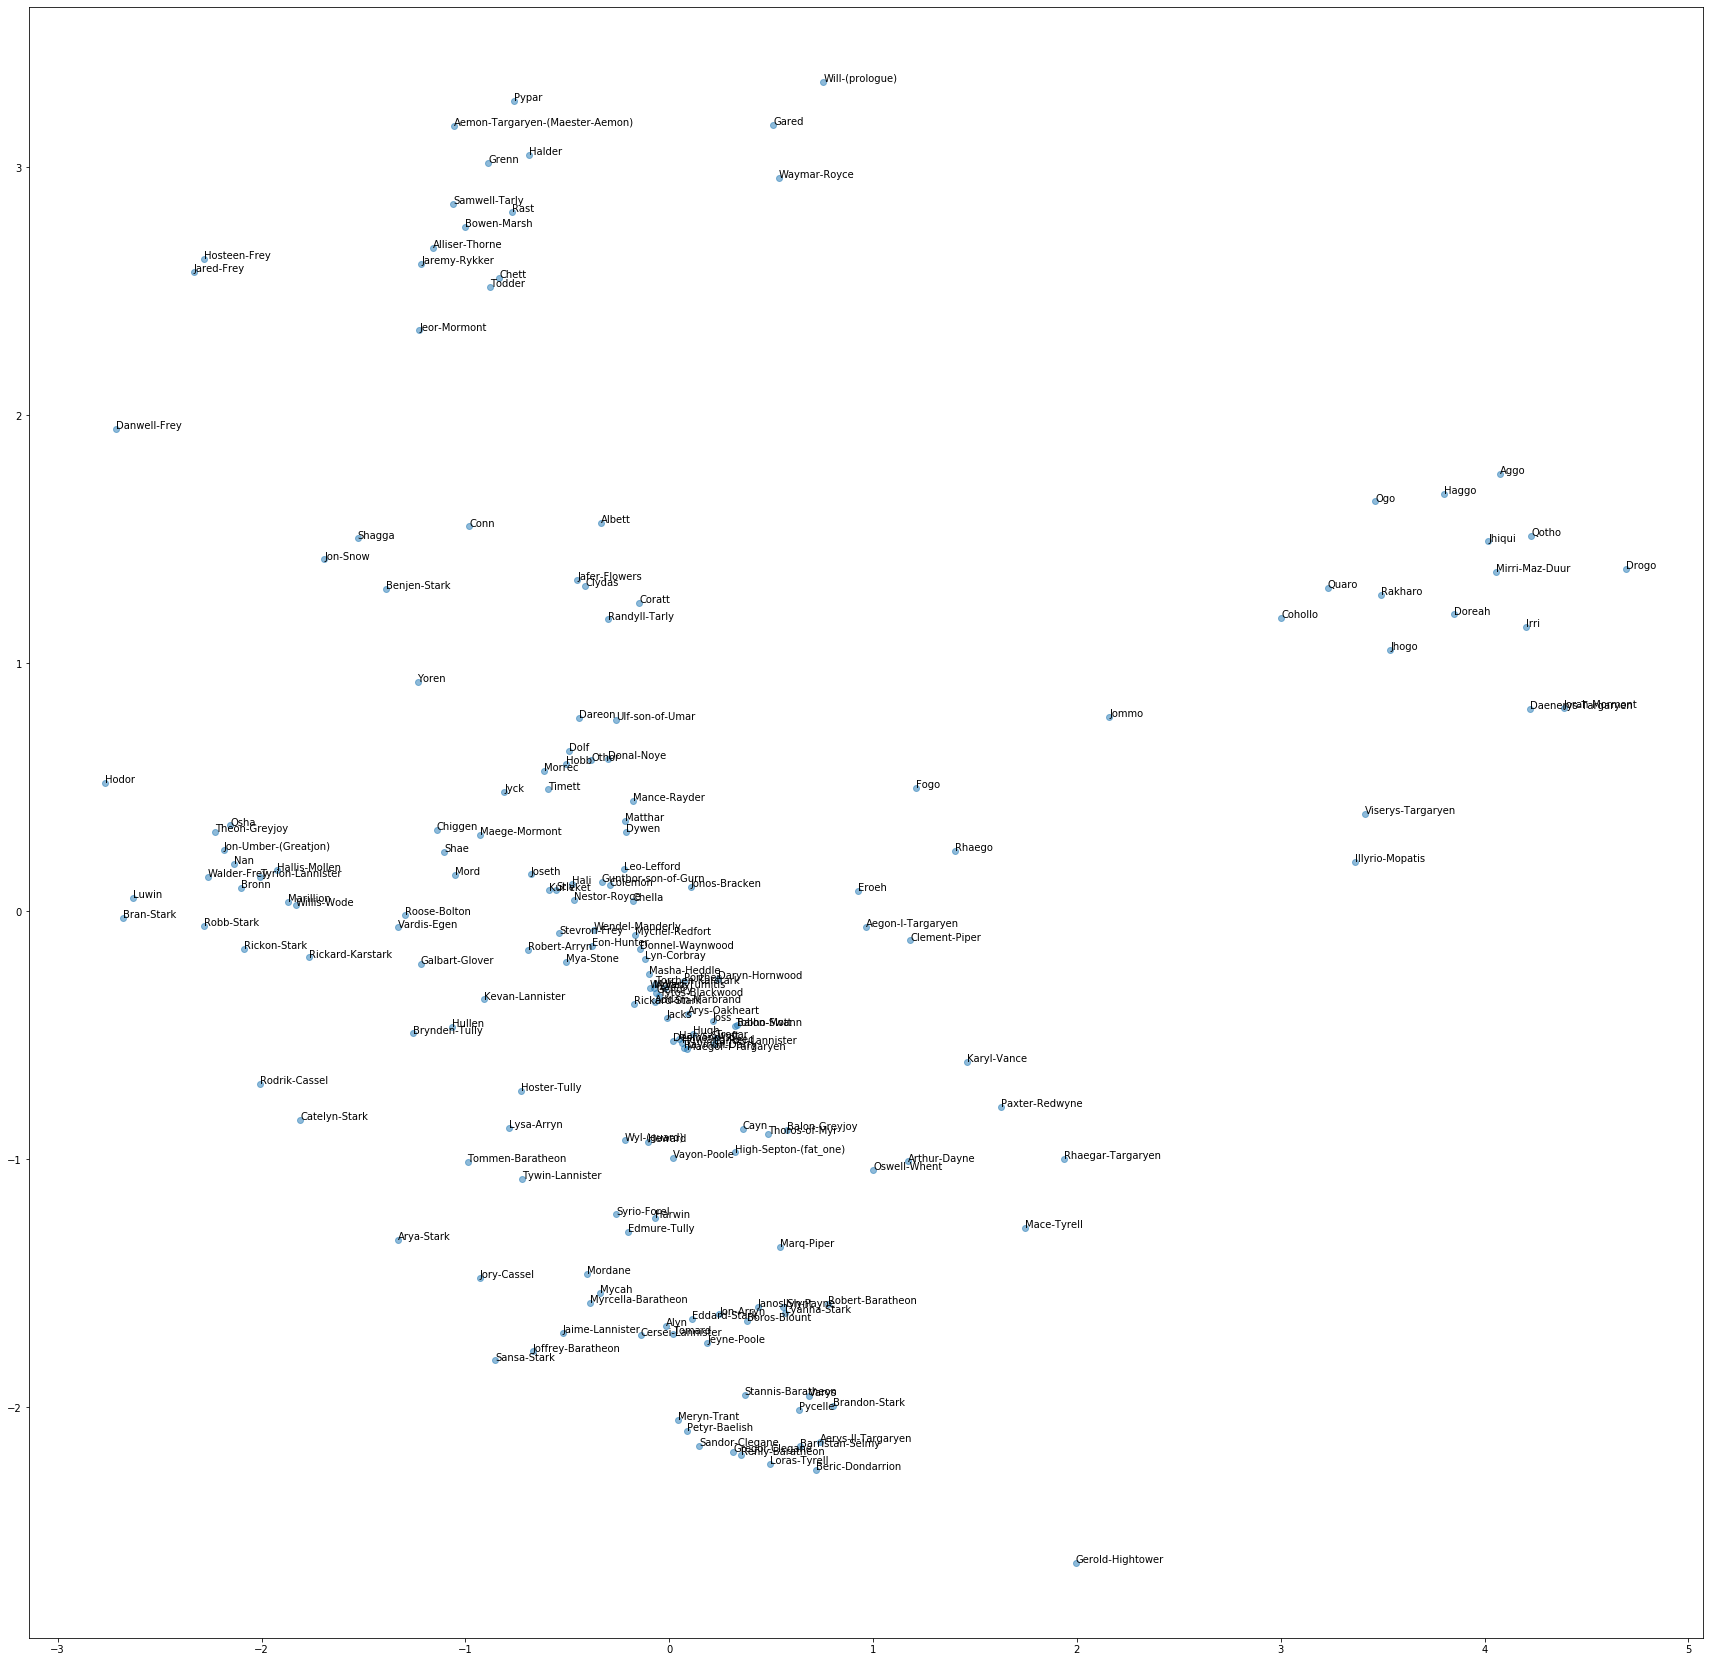

In [74]:
pyplt.figure(figsize=[30, 30])
pyplt.scatter(x, y, alpha=0.5)
x = got_tsne[:,0]
y = got_tsne[:,1]
for i, node in enumerate(G_got.nodes()):
    pyplt.annotate(node, (x[i], y[i]))

Most important characters: characters whose degree centrality is higher

In [40]:
deg_cen_book1 = nx.degree_centrality(G_got)
sorted_deg_cen_book1 =  sorted(deg_cen_book1.items(), key=lambda x:x[1], reverse=True)[0:10]

In [41]:
print(sorted_deg_cen_book1)

[('Eddard-Stark', 0.3548387096774194), ('Robert-Baratheon', 0.2688172043010753), ('Tyrion-Lannister', 0.24731182795698928), ('Catelyn-Stark', 0.23118279569892475), ('Jon-Snow', 0.19892473118279572), ('Robb-Stark', 0.18817204301075272), ('Sansa-Stark', 0.18817204301075272), ('Bran-Stark', 0.17204301075268819), ('Cersei-Lannister', 0.16129032258064518), ('Joffrey-Baratheon', 0.16129032258064518)]
